In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import copy
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [40]:
df = pd.read_csv('/content/first inten project.csv')
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


**check if data contains nulls**

In [41]:
df.isna().sum()

Booking_ID                  0
number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
booking status              0
dtype: int64

**check duplicates**

In [42]:
df.duplicated().sum()

0

so, there is no duplicated or null values

**Ceck columns range**

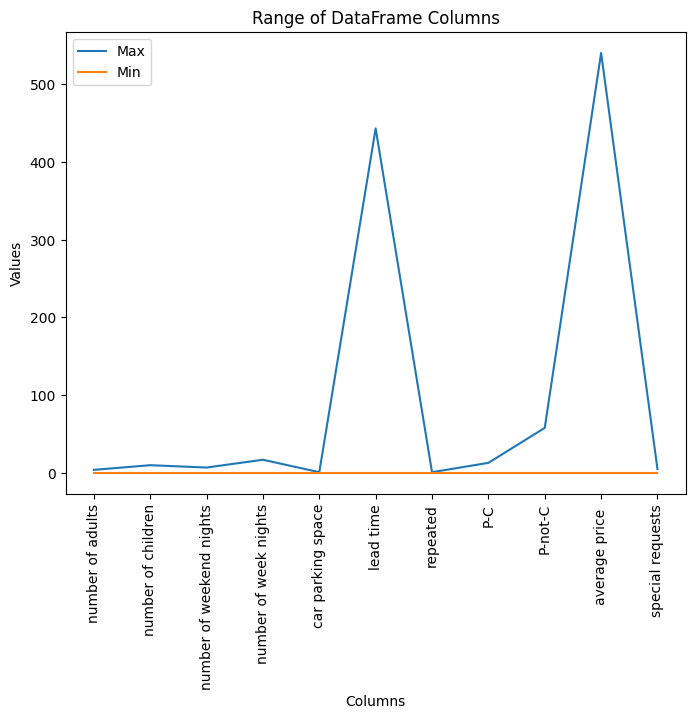

In [43]:
numeric_columns = df.select_dtypes(include=['int', 'float']).columns

df_filtered = df[numeric_columns]
plt.figure(figsize=(8, 6))
plt.plot(df_filtered.columns, df_filtered.max(), label='Max')
plt.plot(df_filtered.columns, df_filtered.min(), label='Min')

plt.title('Range of DataFrame Columns')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.legend()

plt.show()

In [44]:
for column in numeric_columns:
  print(f'{column} --> min = {df.min()[column]}, max = {df.max()[column]}')
  print('--------------------------------')

number of adults --> min = 0, max = 4
--------------------------------
number of children --> min = 0, max = 10
--------------------------------
number of weekend nights --> min = 0, max = 7
--------------------------------
number of week nights --> min = 0, max = 17
--------------------------------
car parking space --> min = 0, max = 1
--------------------------------
lead time --> min = 0, max = 443
--------------------------------
repeated --> min = 0, max = 1
--------------------------------
P-C --> min = 0, max = 13
--------------------------------
P-not-C --> min = 0, max = 58
--------------------------------
average price  --> min = 0.0, max = 540.0
--------------------------------
special requests --> min = 0, max = 5
--------------------------------


In [45]:
df['date of reservation'] = df['date of reservation'].str.replace('29', '28')
df['year'] = pd.to_datetime(df['date of reservation']).dt.year
df['month'] = pd.to_datetime(df['date of reservation']).dt.month

In [46]:
df.drop(columns=['Booking_ID', 'date of reservation'], inplace=True)

In [47]:
df['month'].unique()

array([10, 11,  2,  5,  4,  9, 12,  7,  6,  8,  3,  1])

**add new column contains the all previous canceled and not canceled reservations**

In [48]:
df['prev_reservations'] = df['P-C'] + df['P-not-C']

In [49]:
df['type of meal'] = df['type of meal'].str.replace('Meal Plan ', '')
df['room type'] = df['room type'].str.replace('Room_Type ', '')

encoder = OneHotEncoder(handle_unknown='ignore')

enc_data = pd.DataFrame(encoder.fit_transform(df[['type of meal']]).toarray(), columns = 'type of meal'+'_'+encoder.categories_[0])
df = pd.concat([df.reset_index(drop=True), enc_data.reset_index(drop=True)], axis=1)
df.drop(columns='type of meal', inplace=True)

In [50]:
encoder2 = OneHotEncoder(handle_unknown='ignore')

enc_data = pd.DataFrame(encoder2.fit_transform(df[['room type']]).toarray(), columns = 'room type'+'_'+encoder2.categories_[0])
df = pd.concat([df.reset_index(drop=True), enc_data.reset_index(drop=True)], axis=1)
df.drop(columns='room type', inplace=True)

In [51]:
encoder3 = OneHotEncoder(handle_unknown='ignore')

enc_data = pd.DataFrame(encoder3.fit_transform(df[['market segment type']]).toarray(), columns = 'market segment type'+'_'+encoder3.categories_[0])
df = pd.concat([df.reset_index(drop=True), enc_data.reset_index(drop=True)], axis=1)
df.drop(columns='market segment type', inplace=True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   number of adults                   36285 non-null  int64  
 1   number of children                 36285 non-null  int64  
 2   number of weekend nights           36285 non-null  int64  
 3   number of week nights              36285 non-null  int64  
 4   car parking space                  36285 non-null  int64  
 5   lead time                          36285 non-null  int64  
 6   repeated                           36285 non-null  int64  
 7   P-C                                36285 non-null  int64  
 8   P-not-C                            36285 non-null  int64  
 9   average price                      36285 non-null  float64
 10  special requests                   36285 non-null  int64  
 11  booking status                     36285 non-null  obj

In [53]:
booking_status_encoder = LabelEncoder()
df['booking status'] = booking_status_encoder.fit_transform(df['booking status'])

**Check outliers**

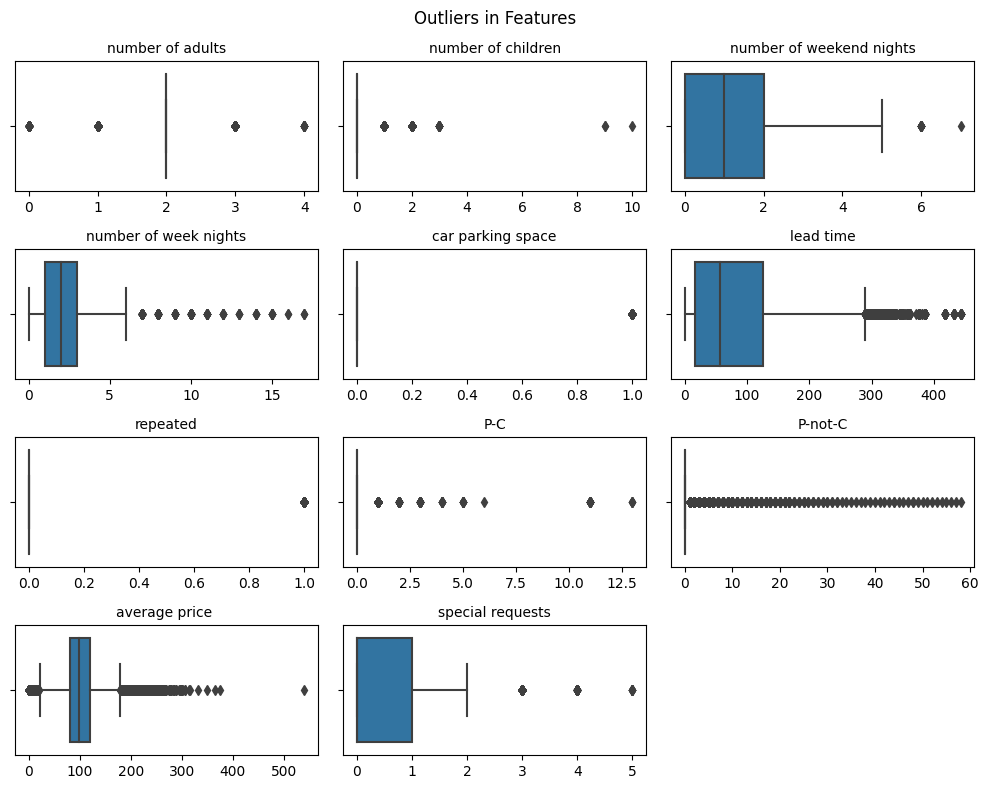

In [54]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,8), dpi=100)
fig.suptitle('Outliers in Features', y = 0.98)
for col, ax in zip(numeric_columns, axes.ravel()):
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_xlabel('')
    ax.set_title(f'{col}', fontsize=10)
fig.delaxes(axes[3, -1])
fig.tight_layout()

**Most of outliers are normal**

In [55]:
def IQR(col):
    q1 = np.percentile(col, 25)
    q3 = np.percentile(col, 75)
    iqr = q3 - q1
    upper_bound = q3 + (1.5 * iqr)
    upper_outliers = col > upper_bound

    # Replace outliers with upper bound values
    col = np.where(upper_outliers, round(upper_bound, 2), col)
    return col

df['lead time'] = IQR(df['lead time'])

**What feature most affects the target?**


In [56]:
correlations = {}
for feature in df.columns:
    if feature != 'booking status':
        correlation, p_value = scipy.stats.spearmanr(df[feature], df['booking status'])
        correlations[feature] = correlation

for feature, correlation in correlations.items():
    print(f"{feature} - booking status: {correlation}")

number of adults - booking status: -0.09062442484982472
number of children - booking status: -0.02752762118940999
number of weekend nights - booking status: -0.05383518665636769
number of week nights - booking status: -0.07987615732456649
car parking space - booking status: 0.08617927271299093
lead time - booking status: -0.41810809809210686
repeated - booking status: 0.10727668000424745
P-C - booking status: 0.05791228802122762
P-not-C - booking status: 0.10284664017725899
average price  - booking status: -0.1606699910253456
special requests - booking status: 0.2563039282544227
year - booking status: -0.17934690032165093
month - booking status: 0.03233920970280947
prev_reservations - booking status: 0.10727996903164913
type of meal_1 - booking status: 0.06136567642618293
type of meal_2 - booking status: -0.08646776811626353
type of meal_3 - booking status: 0.0031929192691044854
type of meal_Not Selected - booking status: -0.0031120608544704135
room type_1 - booking status: 0.020205151

we see that [lead time] and [special requests] is the top features

In [57]:
tmp = [[None]*2 for _ in range(len(df['special requests'].unique())+1)]
for i in df['special requests'].unique():
  for j in range(2):
    count = (df['special requests'] == i) & (df['booking status'] == j)
    tmp[i][j] = count.sum()

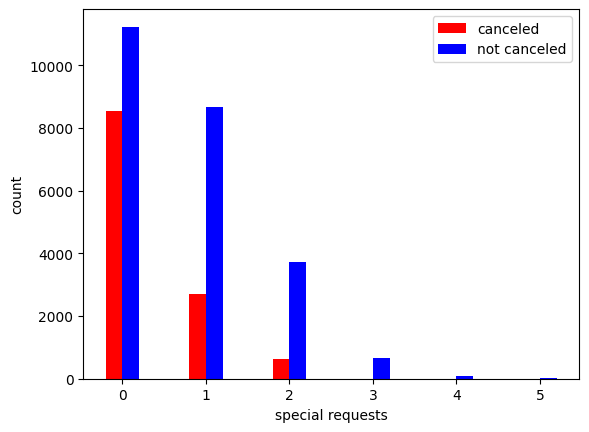

In [58]:
plt.bar([i-0.1 for i in range(6)], [tmp[i][0] for i in range(6)], 0.2, color = "red")
plt.bar([i+0.1 for i in range(6)], [tmp[i][1] for i in range(6)], 0.2, color = "blue")

plt.legend(["canceled", "not canceled"])
plt.xlabel('special requests')
plt.ylabel("count")

plt.show()

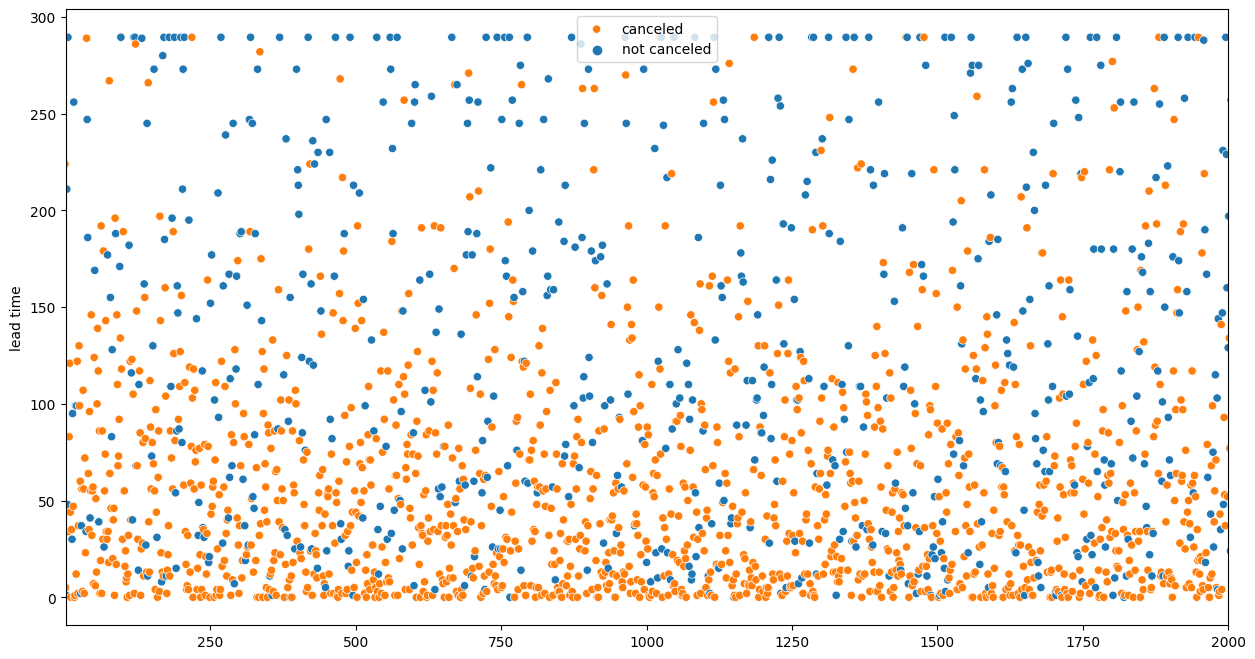

In [59]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=df.index, y=df['lead time'], hue=df['booking status'], ax=ax)
ax.set_xlim(1, 2000)
ax.legend(labels=['canceled', 'not canceled'])
plt.show()

In [60]:
X = df.drop(columns=['booking status'])
y = df['booking status']

**Feature Selection**

In [61]:
selector = SelectKBest(f_classif, k=22)
best_features = selector.fit_transform(X, y)
selected_features = list(X.columns[selector.get_support()])
selected_features

['number of adults',
 'number of children',
 'number of weekend nights',
 'number of week nights',
 'car parking space',
 'lead time',
 'repeated',
 'P-C',
 'P-not-C',
 'average price ',
 'special requests',
 'year',
 'prev_reservations',
 'type of meal_1',
 'type of meal_2',
 'room type_1',
 'room type_6',
 'room type_7',
 'market segment type_Complementary',
 'market segment type_Corporate',
 'market segment type_Offline',
 'market segment type_Online']

In [62]:
to_drop = list(set(X.columns) - set(selected_features))
to_drop

['type of meal_3',
 'market segment type_Aviation',
 'month',
 'type of meal_Not Selected',
 'room type_2',
 'room type_4',
 'room type_3',
 'room type_5']

In [63]:
X.drop(columns=to_drop, inplace=True)
X.head()

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,...,prev_reservations,type of meal_1,type of meal_2,room type_1,room type_6,room type_7,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online
0,1,1,2,5,0,224.0,0,0,0,88.00,...,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,1,3,0,5.0,0,0,0,106.68,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,1,1,3,0,1.0,0,0,0,50.00,...,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,0,2,0,211.0,0,0,0,100.00,...,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0,1,2,0,48.0,0,0,0,77.00,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,...,prev_reservations,type of meal_1,type of meal_2,room type_1,room type_6,room type_7,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online
0,0.25,0.1,0.285714,0.294118,0.0,0.773748,0.0,0.0,0.0,0.162963,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.25,0.0,0.142857,0.176471,0.0,0.017271,0.0,0.0,0.0,0.197556,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.1,0.142857,0.176471,0.0,0.003454,0.0,0.0,0.0,0.092593,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.25,0.0,0.000000,0.117647,0.0,0.728843,0.0,0.0,0.0,0.185185,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.25,0.0,0.142857,0.117647,0.0,0.165803,0.0,0.0,0.0,0.142593,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
def make_report(pred, model_name, pos1, pos2=[0.5, -0.4]):
  labels = ['Canceled', 'Not_Canceled']

  plt.figure(figsize=(8, 10))
  plt.subplot(2, 1, 1)

  cf_matrix = confusion_matrix(y_test, pred)
  sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, fmt='g', xticklabels=labels, yticklabels=labels)
  plt.title('confusion matrix')
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.text(pos1[0], pos1[1],f"{model_name}\n\n", fontdict={'size':25, 'weight': 'bold'})
  plt.text(pos2[0], pos2[1],f"Accuracy: {accuracy_score(y_test, pred) * 100:.2f}%", fontdict={'size':13})



  report_dict = classification_report(y_test, pred, output_dict=True, target_names=labels)
  report_df = pd.DataFrame(report_dict).transpose()

  report_df['precision']['accuracy']=None
  report_df['recall']['accuracy']=None
  report_df['support']['accuracy'] = report_df['support']['macro avg']

  plt.subplot(2, 1, 2)
  sns.heatmap(report_df, annot=True, fmt=".2f", cmap='YlGnBu', cbar=False, vmin=0, vmax=1)
  plt.title('Classification Report')
  plt.tight_layout(pad=5.0)
  plt.show()

def plot_roc(model_name, model):
  y_pred_proba = model.predict_proba(X_test)[::, 1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr, tpr, label="auc="+str(auc))
  plt.title(f'ROC curve for {model_name}')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc=4)
  plt.show()

In [67]:
logistic_grid = {
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'sag', 'lbfgs', 'saga']
}
grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), logistic_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best parameters : {grid.best_params_}")

logisticRegression = grid.best_estimator_
y_pred_logreg = logisticRegression.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg) * 100:.2f}%")

Best parameters : {'C': 10, 'solver': 'newton-cg'}
Accuracy: 80.90%


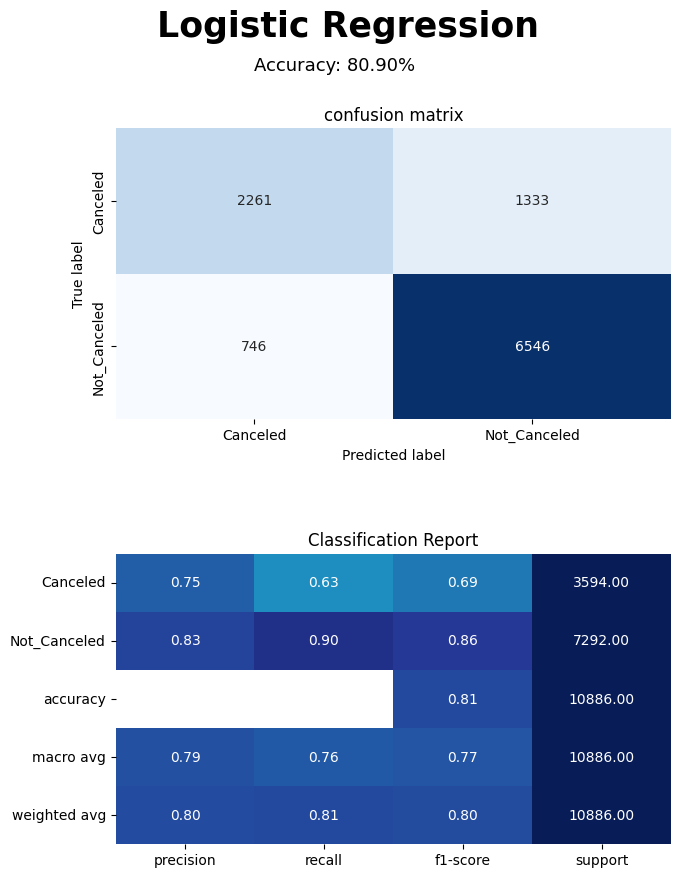

In [68]:
make_report(y_pred_logreg, 'Logistic Regression', [0.15, -0.09], [0.5, -0.4])

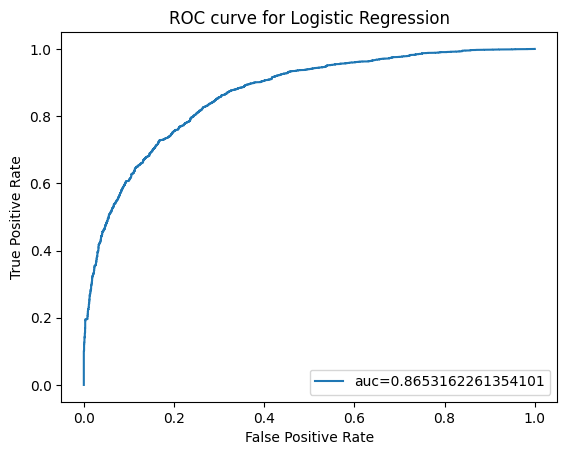

In [69]:
plot_roc('Logistic Regression', logisticRegression)

In [70]:
Decision_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}
grid = GridSearchCV(DecisionTreeClassifier(), Decision_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best parameters : {grid.best_params_}")

DecisionTree = grid.best_estimator_
y_pred_Dtree = DecisionTree.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_Dtree) * 100:.2f}%")

Best parameters : {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 80.90%


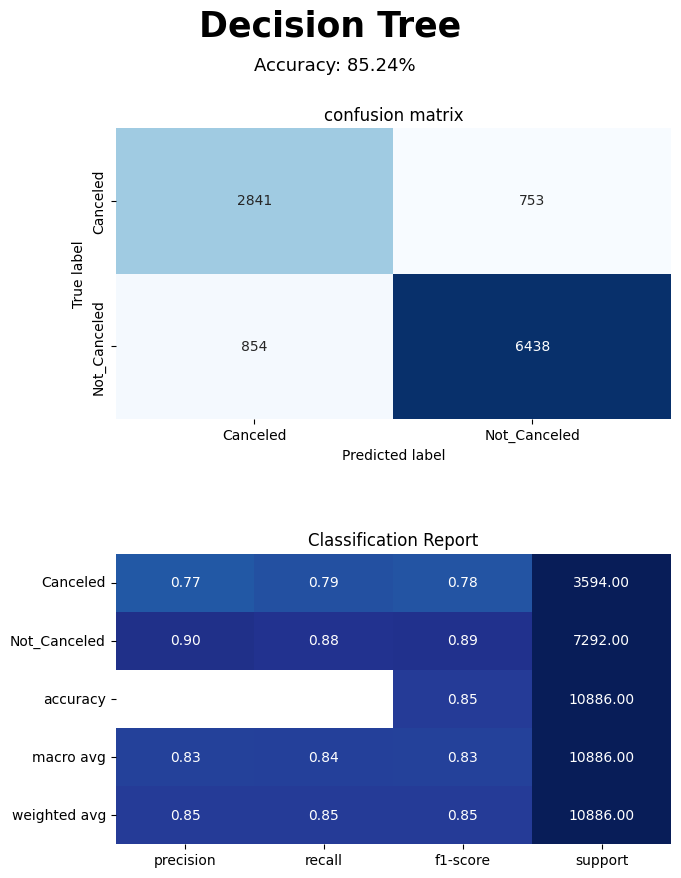

In [71]:
make_report(y_pred_Dtree, 'Decision Tree', [0.3, -0.09])

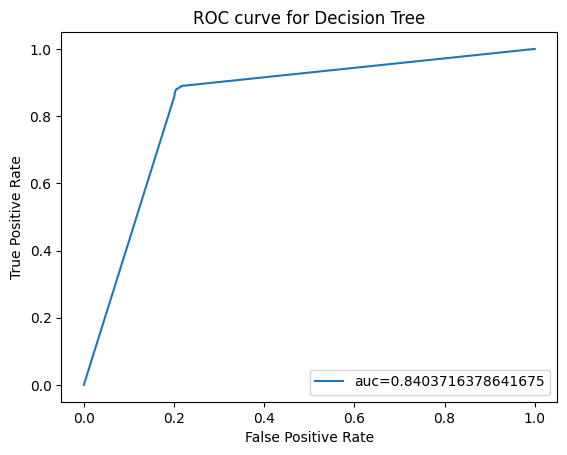

In [72]:
plot_roc('Decision Tree', DecisionTree)

In [73]:
Random_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [2, 3, 4, 5, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]}
grid = GridSearchCV(RandomForestClassifier(random_state=42), Random_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best parameters : {grid.best_params_}")

RandomForest = grid.best_estimator_
y_pred_random = RandomForest.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_random) * 100:.2f}%")

Best parameters : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}
Accuracy: 88.89%


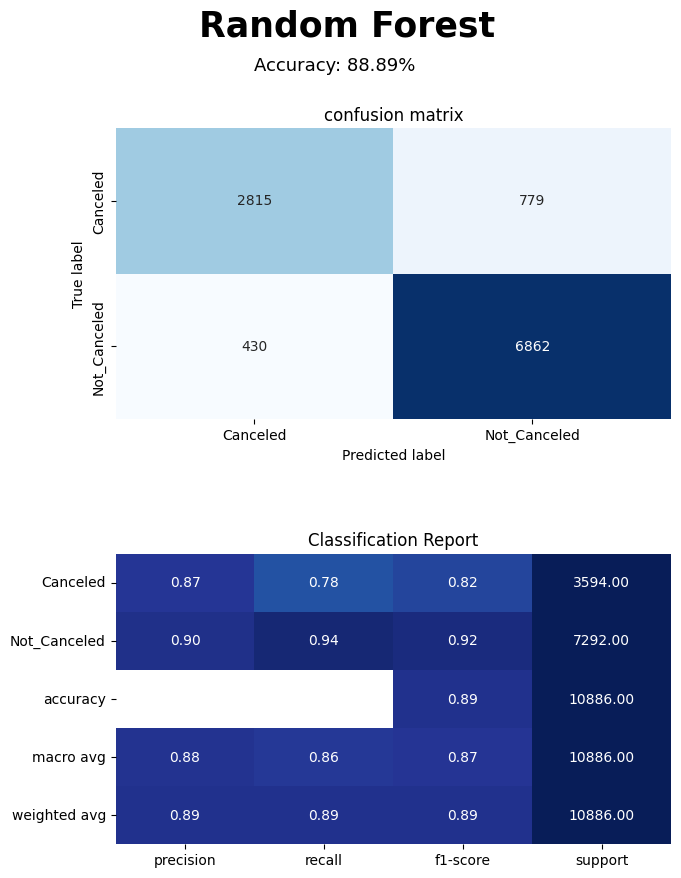

In [74]:
make_report(y_pred_random, 'Random Forest', [0.3, -0.09])

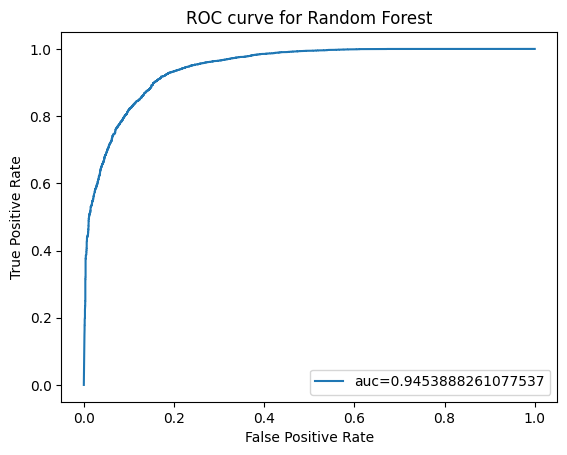

In [75]:
plot_roc('Random Forest', RandomForest)

In [76]:

knn_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
grid = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best parameters : {grid.best_params_}")

knn = grid.best_estimator_
y_pred_knn = knn.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn) * 100:.2f}%")

Best parameters : {'n_neighbors': 7}
Accuracy: 85.15%


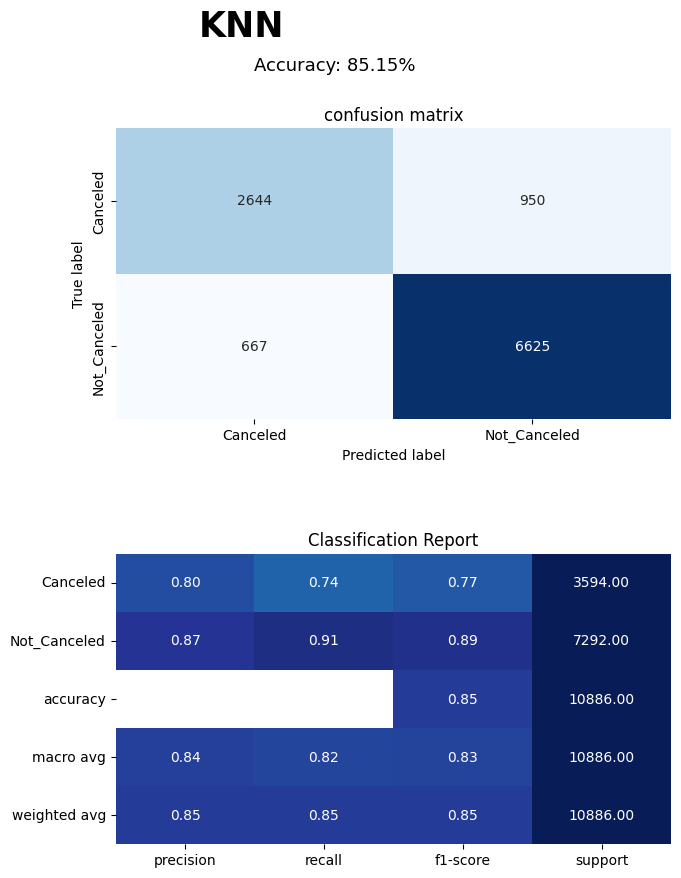

In [77]:
make_report(y_pred_knn, 'KNN', [0.3, -0.09])

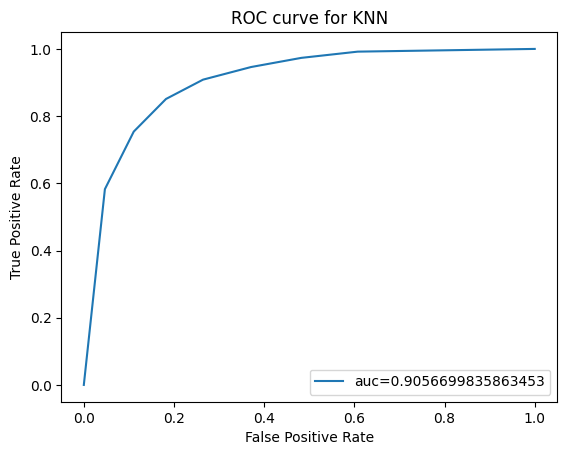

In [78]:
plot_roc('KNN', knn)

In [79]:
svc_grid= {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'dual': [False, True]
}
svc_model = LinearSVC(random_state=42, max_iter=5000)

grid_search = GridSearchCV(svc_model, svc_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best parameters : {grid_search.best_params_}")

svc_model = grid_search.best_estimator_
y_pred_svc = svc_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc) * 100:.2f}%")

Best parameters : {'C': 10.0, 'dual': False, 'penalty': 'l2'}
Accuracy: 80.73%


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty,

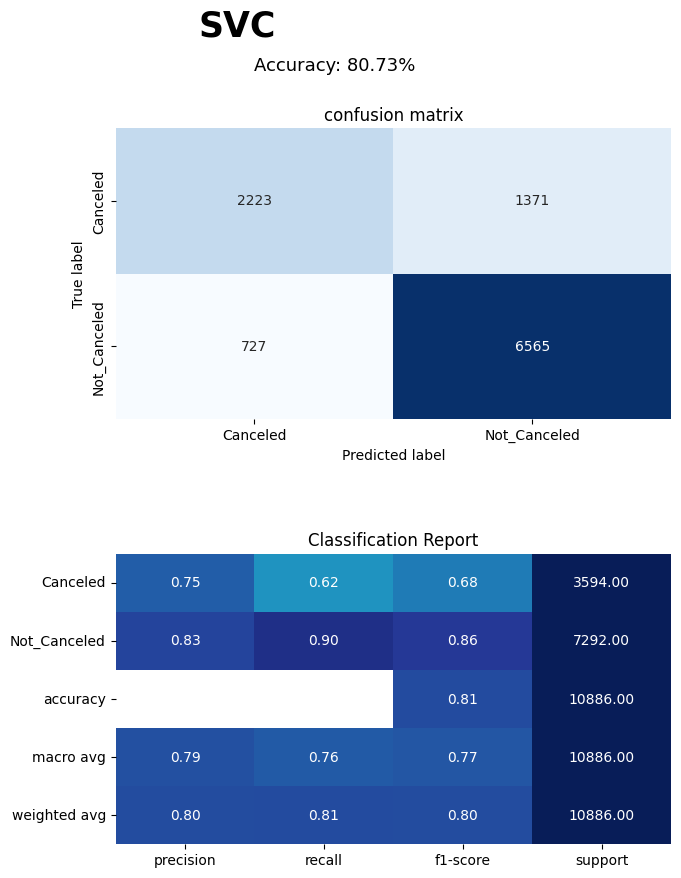

In [80]:
make_report(y_pred_svc, 'SVC', [0.3, -0.09])

In [81]:
pickle.dump(RandomForest, open('model.sav', 'wb'))

encoders = {'type of meal':encoder, 'room type':encoder2, 'market segment type':encoder3, 'booking status':booking_status_encoder}
pickle.dump(encoders, open('encoders.sav', 'wb'))

pickle.dump(to_drop, open('to_drop_features.sav', 'wb'))

pickle.dump(scaler, open('scaler.sav', 'wb'))